In [7]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as pl
import numpy as np
import kontin as con
import danframe as dan
import testwin as tw
pl.rcParams["figure.figsize"] = (10,6) # Bigger figures

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Initial stability tests
=======================
Doing linear fits to the spectrum points that fall inside some wavelength window. These windows are selected both manually (by visual inspection) and with several simplistic but automatic routines: 

* the 20 highest points
* the 100 highest points
* the highest 5% of the points
* the points in the second highest 5% interval, ie the 90 % to 95 %
* those points of the spectra with values above one
* some few points around the top value
* the highes values from each part of a partition of the upper half of the points

All these selections happens using the mean spectra adjusted to match the Kitt peak FTS atlas. The functions are found in *kontin.py*, mainly in *select_bgwin_auto*.

As a first attempt to study the stability of the fit resulting from using each of the windows I have defined is implemented by *perturb_window_fit* in *testwin.py*. It works in the following way: I selected random subsets (of fixed size) of the complete set of points in each window and do a linear least squares fit to these points. Using the result of the fit I then calculate the fitted continuum level in the centre of the wavelength range the spectra cover, and save that value as my test statistic. 

Repeating this 5000 time I calculate a standard deviation and use that as an estimate for the stability of the fit. I have done this for ten different sizes of the subsets (ten different percentages of the total points in a window created by a given method). 

## Demonstration
First I load a spectra using my own custom class that simplifies the file handling:

In [11]:
fil2 = "local_data/6405_aS1_397_cor.fits"
spec2 = dan.danframe_sac(fil2)

Then I generate the windows using all both automatic and manual selection, and then explore how perturbing these windows affects the continuum fit.

In [12]:
%%capture
wins = tw.gen_all_auto_wins(spec2)
wins = tw.gen_man_win(spec2,wins)
pt = tw.perturb_all_windows(spec2,wins,5000)

Using the results of the 5000 perburbation rounds of the fits for various sub-selection sizes I can make the following plots

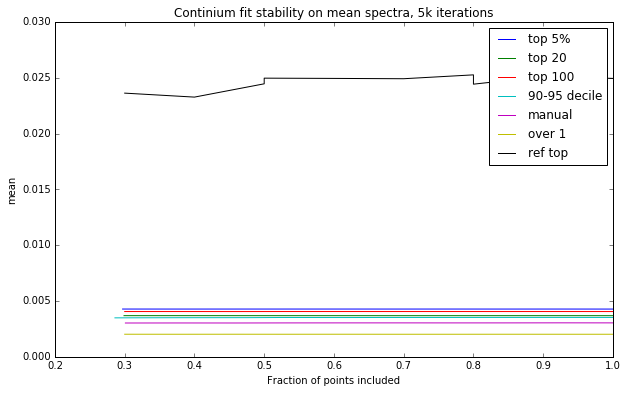

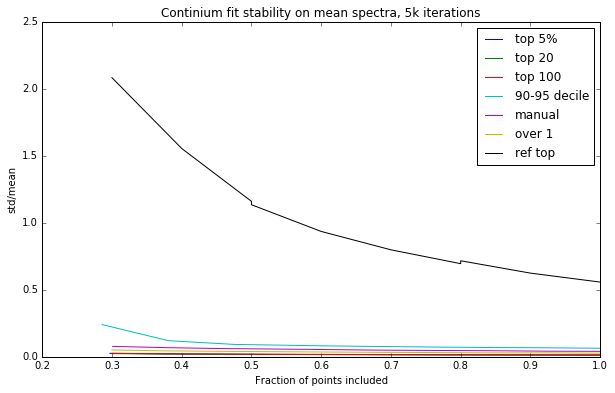

In [13]:
# The evolution of the mean
pl.plot(pt["top 5%"][:,0], pt["top 5%"][:,1],label="top 5%")
pl.plot(pt["top 20"][:,0], pt["top 20"][:,1],label="top 20")
pl.plot(pt["top 100"][:,0], pt["top 100"][:,1],label="top 100")
pl.plot(pt["90-95 decile"][:,0], pt["90-95 decile"][:,1],label="90-95 decile")
pl.plot(pt["manual"][:,0], pt["manual"][:,1],label="manual")
pl.plot(pt["over 1"][:,0], pt["over 1"][:,1],label="over 1")
pl.plot(pt["ref top"][:,0], pt["ref top"][:,1],label="ref top")
pl.title("Continium fit stability on mean spectra, 5k iterations")
pl.ylabel("mean")
pl.xlabel("Fraction of points included")
pl.legend()
pl.show()

# The evolution of the relative variance
pl.plot(pt["top 5%"][:,0], pt["top 5%"][:,3],label="top 5%")
pl.plot(pt["top 20"][:,0], pt["top 20"][:,3],label="top 20")
pl.plot(pt["top 100"][:,0], pt["top 100"][:,3],label="top 100")
pl.plot(pt["90-95 decile"][:,0], pt["90-95 decile"][:,3],label="90-95 decile")
pl.plot(pt["manual"][:,0], pt["manual"][:,3],label="manual")
pl.plot(pt["over 1"][:,0], pt["over 1"][:,3],label="over 1")
pl.plot(pt["ref top"][:,0], pt["ref top"][:,3],label="ref top")
pl.title("Continium fit stability on mean spectra, 5k iterations")
pl.ylabel("std/mean")
pl.xlabel("Fraction of points included")
pl.legend()
pl.show()



The "ref top" method stands out as the one predicting by far the largest continuum value, and also for the greatest variance. 

Next I do a least squares fit to the data using these window definitions and calculate the corresponding continuum value in the centre of the wavelenght interval. Because these spectra resolve surface features, directly plotting the resulting central continua values is not very enligthening. For example: 

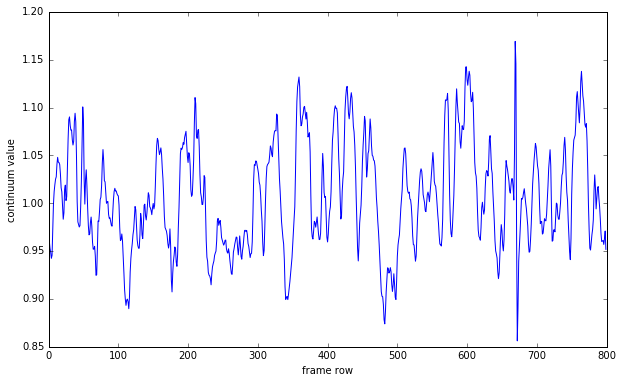

In [14]:
ccont = tw.gen_frame_continuum(spec2,wins["top 5%"])
pl.plot(ccont)
pl.xlabel("frame row")
pl.ylabel("continuum value")
pl.show()

Comparing the difference between the methods becomes much easier if I subtract away the effects of the surface variation. However, I don't know what the real continuum level was so I must approximate it with something. I do this by subtracting the ensamble mean, or the ensamble median, or by subtracting the average of five clumns on either side of the column containing the highest pixel in the FTS convolved spectra. 

These three metods all produce residuals that are substatially more behaved, and can meaningfully be plotted as histograms. With care it is also possible to make some qualitative statemens about their relative performance.

First the comparison of the continuum fits using the ensamble mean as the proxy for the variation of the true surface continuum along the slit:

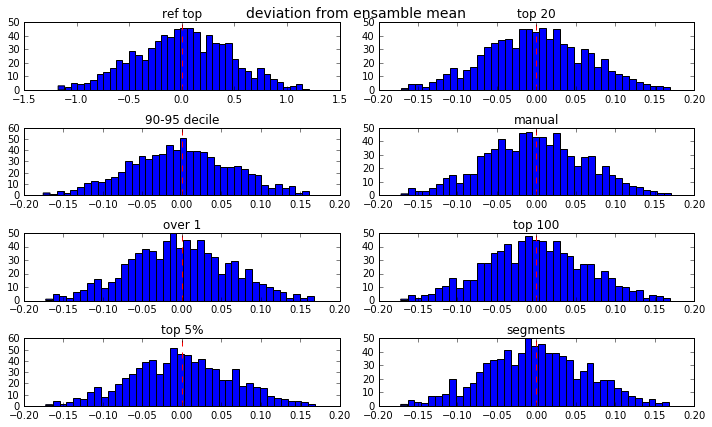


deviation from ensamble mean

               mean       std
     ref top: +9.2192e-03 4.4575e-01
      top 20: -1.1206e-03 6.3631e-02
90-95 decile: -9.9130e-04 6.4242e-02
      manual: -1.7837e-03 6.3668e-02
      over 1: -2.7843e-03 6.3696e-02
     top 100: -1.1715e-03 6.3681e-02
      top 5%: -5.9250e-04 6.3595e-02
    segments: -7.7530e-04 6.3587e-02


In [15]:
menmean,menstd = tw.compare_win_continua(spec2,wins,centre="mean",plot=True)

The inclusiong of the "ref top" window definition is what leads to all the histograms being nicely centred around 0. It migh also be responsible for the strange behaviour of the distribution of residuals from the ensamble median:

In [ ]:
menmean,menstd = tw.compare_win_continua(spec2,wins,centre="median",plot=True)

Finally then is the residuals distribution when using the mean of the 11 columns centered around the column containing the maximum value of the FTS convolved spectra.

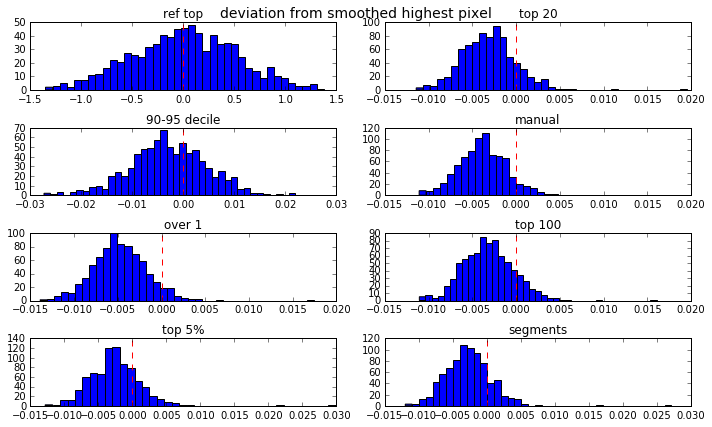


deviation from smoothed highest pixel

               mean       std
     ref top: +7.2147e-03 5.0942e-01
      top 20: -3.1251e-03 3.1155e-03
90-95 decile: -2.9957e-03 7.4344e-03
      manual: -3.7881e-03 2.8664e-03
      over 1: -4.7887e-03 3.0687e-03
     top 100: -3.1759e-03 2.9482e-03
      top 5%: -2.5969e-03 3.6060e-03
    segments: -2.7797e-03 3.4032e-03


In [16]:
refmean,refstd = tw.compare_win_continua(spec2,wins,centre="smoothmax",plot=True)

A further test is measuring how much of the spectra remains over the continium level after some smoothing has (hopefully) removed the noise that is the only component of the observed signal that can be expected to lie over the continuum level. This was done by fitting a continuum for each row using one of the windows, and then subtracting it away before rolling mean smoothing.

Looking first at some examples of how it can appear (the first example has two outliers at either end that are impossible to see):

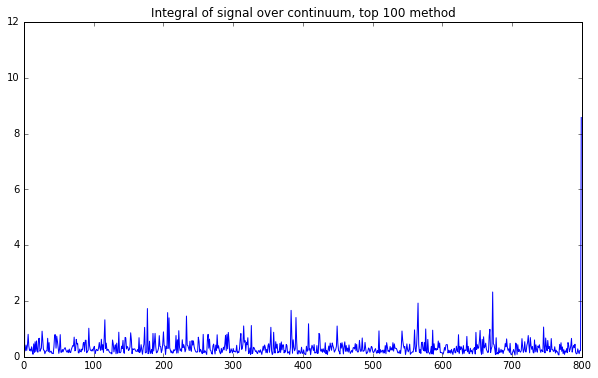

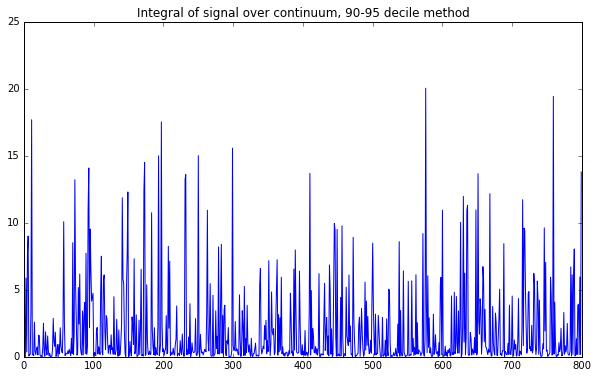

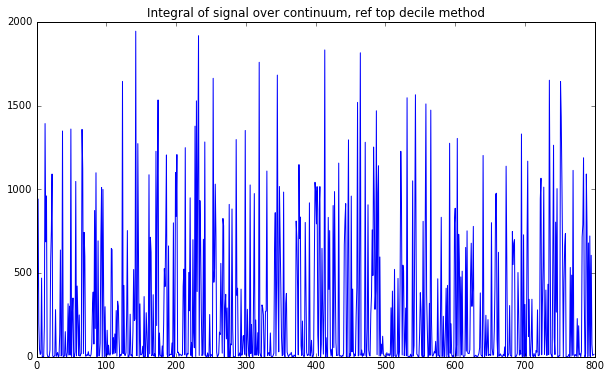

In [17]:
smooth_lmbd,smooth_spec,subtr =  tw.smooth_test(spec2,wins["top 100"],size = 10)
pl.plot(subtr[:,0]) #First and last row contain large outliers
pl.title("Integral of signal over continuum, top 100 method")
pl.show()

smooth_lmbd,smooth_spec,subtr =  tw.smooth_test(spec2,wins["90-95 decile"],size = 10)
pl.plot(subtr[:,0]) 
pl.title("Integral of signal over continuum, 90-95 decile method")
pl.show()

smooth_lmbd,smooth_spec,subtr =  tw.smooth_test(spec2,wins["ref top"],size = 10)
pl.plot(subtr[:,0])
pl.title("Integral of signal over continuum, ref top decile method")
pl.show()

Looking at it more qualitatively, the following shows the histogram of the above residuals (and including those left out above):


Integral of signal over continuum

              mean    std     max      max_row
     ref top: 278.876 415.779 1944.928 142
      top 20:   0.358   0.562   12.606 0
90-95 decile:   1.990   3.226   24.754 0
      manual:   0.493   0.413    8.615 0
      over 1:   0.709   0.492   10.667 0
    segments:   0.380   0.551   12.468 0
      top 5%:   0.364   0.533   10.036 0
     top 100:   0.351   0.535   10.913 0


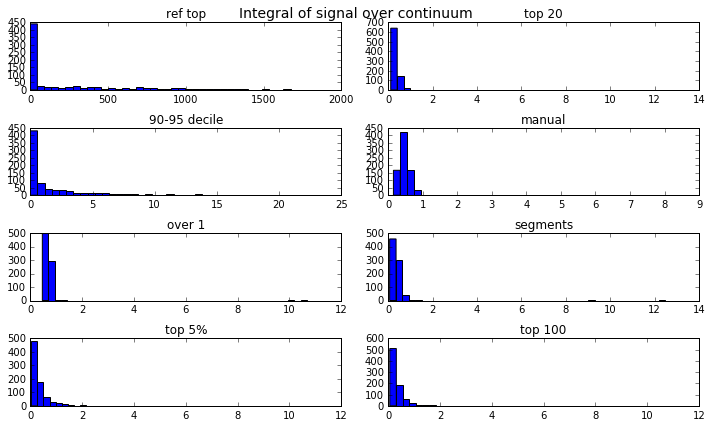

In [18]:
tw.all_smooth_test(spec2,wins,smooth=10,plot=True)

Here the various "top" methods seem to be doing well, with small average error (and variance of that error), even if the manual selection has the smallest max error.

### Poisson noise added to reference spectra
Poisson noise i generated based on the average value of the contint file times the spectra, that is the average continium level before normalizing times the spectra. This is done to get approximate photon counts so that poisson statistics can be used at all.

There isn't much interesting revealed by this test, it agrees more or less with the other ones.


distribution of intercept

              ref        mean       std/mean   95 decile 
     ref top    8.50470    -5.7184  -609.6228  5773.9591
     top 100    0.06823     0.2347    39.4154    15.4690
      over 1    0.54137     0.5381     6.2282     6.1383
    segments   -0.33746    -0.3723   -22.3127    13.2746
      top 5%    0.03955     0.0688   165.7986    18.7372
90-95 decile    0.20006     0.6981    79.3825    92.8574
      top 20    0.03943    -0.0099  -662.4185    10.7405

distribution of slope

              ref        mean       std/mean   95 decile 
     ref top   -0.01170    -5.7184  -609.6228  5773.9591
     top 100    0.00146     0.2347    39.4154    15.4690
      over 1    0.00072     0.5381     6.2282     6.1383
    segments    0.00209    -0.3723   -22.3127    13.2746
      top 5%    0.00151     0.0688   165.7986    18.7372
90-95 decile    0.00125     0.6981    79.3825    92.8574
      top 20    0.00150    -0.0099  -662.4185    10.7405

Excess

              ref        

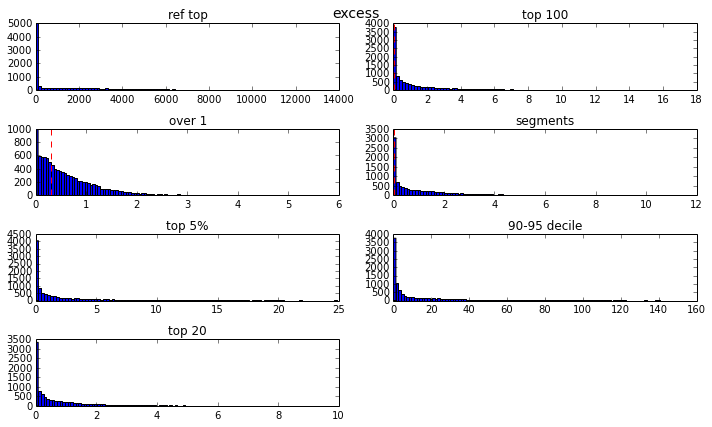

In [7]:
result = tw.test_fit_with_noise(spec2,rows=1e4,plot_excess=True,bins=103)